# Brain Tumor diagnostic MRI Image Classification

### Preprocessing Data

In [0]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [0]:
!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/30 no.jpg  
   creating: __MACOSX/
   creating: __MACOSX/brain_tumor_dataset/
   creating: __MACOSX/brain_tumor_dataset/no/
  inflating: __MACOSX/brain_tumor_dataset/no/._30 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._22 no.jpg  
  inflating: brain_tumor_dataset/no/41 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._41 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._14 no.jpg  
  inflating: brain_tumor_dataset/no/no 10.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._no 10.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._18 no.jpg  
  inflating: brain_tumor_dataset/no/no 9.png  
  inflating: __MACOSX/brain_tumor_dataset/no/._no 9.png  
  inflating: brain_tumor_dataset/no/

In [0]:
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) 

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y163.JPG', 'brain_tumor_dataset/yes/Y75.JPG', 'brain_tumor_dataset/yes/Y40.JPG', 'brain_tumor_dataset/yes/Y108.jpg', 'brain_tumor_dataset/yes/Y186.jpg', 'brain_tumor_dataset/yes/Y71.JPG', 'brain_tumor_dataset/yes/Y30.jpg', 'brain_tumor_dataset/yes/Y59.JPG', 'brain_tumor_dataset/yes/Y165.JPG', 'brain_tumor_dataset/yes/Y74.jpg', 'brain_tumor_dataset/yes/Y61.jpg', 'brain_tumor_dataset/yes/Y195.JPG', 'brain_tumor_dataset/yes/Y18.JPG', 'brain_tumor_dataset/yes/Y42.jpg', 'brain_tumor_dataset/yes/Y250.jpg', 'brain_tumor_dataset/yes/Y54.jpg', 'brain_tumor_dataset/yes/Y161.JPG', 'brain_tumor_dataset/yes/Y28.jpg', 'brain_tumor_dataset/yes/Y8.jpg', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y31.jpg', 'brain_tumor_dataset/yes/Y109.JPG', 'brain_tumor_dataset/yes/Y60.jpg', 'brain_tumor_dataset/yes/Y89.JPG', 'brain_tumor_dataset/yes/Y120.JPG', 'brain_tumor_dataset/yes/Y24.jpg', 'brain_tumor_dataset/yes/Y246.JPG'

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')

print(type(img))
print(img.format)
print(img.mode)
print(img.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


Using TensorFlow backend.


In [0]:
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) 
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) 
        img=img.reshape((224,224,3)) 
        return img

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

X= np.array(preprocessed_image_data) 

In [0]:
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))

y_labels = yes+no

print(len(y_labels) )

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


### Visualize Images and their Labels

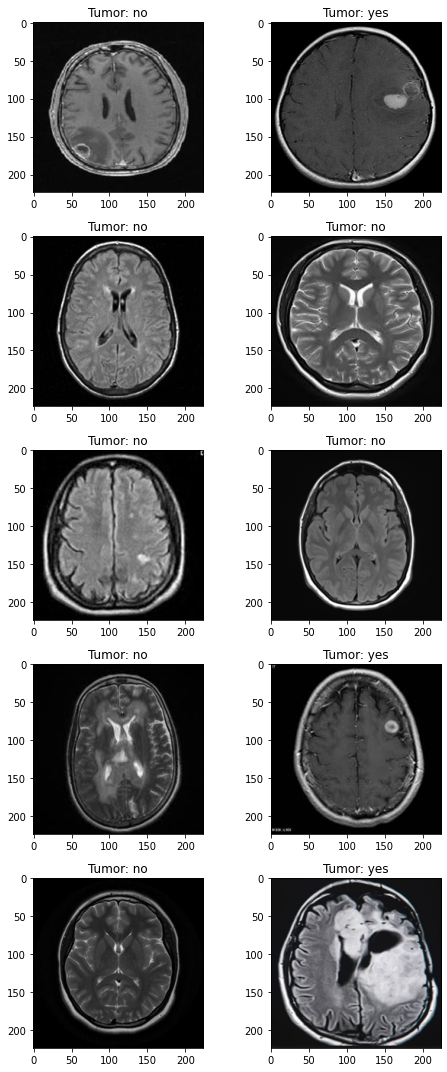

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 

,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


### Motivation

While I think using a predictive model using the MRI brain images might be useful in streamlining the processes around diagnosing, treating and triaging patients with brain tumor, these models should not replace a physician who would need to act as a preliminary diagnostician.  

Similar models built on chest x-ray image data that identify pleural effusion can, however be used in cases such as the current pandamic to traige *established* covid patients from one hospital unit to another or to categorize patienst based on their prognosis. 

### Model 1: Neural Network with Four Hidden Layers

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): 
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
7/7 [==============================] - 32s 5s/step - loss: 0.6427 - accuracy: 0.6139 - val_loss: 0.6887 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 32s 5s/step - loss: 0.6234 - accuracy: 0.6337 - val_loss: 0.6682 - val_accuracy: 0.5294
Epoch 3/10
7/7 [==============================] - 33s 5s/step - loss: 0.5955 - accuracy: 0.6337 - val_loss: 0.6742 - val_accuracy: 0.5294
Epoch 4/10
7/7 [==============================] - 32s 5s/step - loss: 0.5807 - accuracy: 0.6337 - val_loss: 0.6781 - val_accuracy: 0.5294
Epoch 5/10
7/7 [==============================] - 33s 5s/step - loss: 0.5791 - accuracy: 0.6337 - val_loss: 0.6717 - val_accuracy: 0.5294
Epoch 6/10
7/7 [==============================] - 34s 5s/step - loss: 0.5751 - accuracy: 0.6337 - val_loss: 0.6520 - val_accuracy: 0.5294
Epoch 7/10
7/7 [==============================] - 32s 5s/step - loss: 0.5781 - accuracy: 0.6386 - val_loss: 0.6353 - val_accuracy: 0.5294
Epoch 8/10
7/7 [==================

In [0]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 512ms/step - loss: 0.6322 - accuracy: 0.5882


[0.6321585774421692, 0.5882353186607361]

As seen above, I got the accuracy of almost 59 percent using a plain vanilla neural network. 

### Model 2: Convolutional Neural Network

In [0]:
with tf.device('/device:GPU:0'): 

  model2 = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
  ])
 
  model2.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  model2.summary()
  
  model2.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_data=(X_test,y_test))
  
  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)       

In [0]:
model2.evaluate(X_test,y_test)

2/2 [==============================] - 0s 214ms/step - loss: 0.4936 - accuracy: 0.7451


[0.49356430768966675, 0.7450980544090271]

This model looks a lot more promissing than the plain vanilla neural network as the accuracy has increased by about 15%. This model is 74.5% accurate. With around 40,000 trainable parameters, one would expect the accuracy of this model to be greater.

### Model 3: Transfer Learning with VGG16

In [0]:
from tensorflow.keras.applications import VGG16

model3 = VGG16(weights=None,input_shape=(224,224,3),include_top=False) 

model3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model3.trainable = False

model3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
modelthree = Sequential([
  model3,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

modelthree.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'): 

  modelthree.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  modelthree.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  modelthree.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
7/7 [==============================] - 110s 16s/step - loss: 0.6922 - acc: 0.6337 - val_loss: 0.6926 - val_acc: 0.5294
Epoch 2/10
7/7 [==============================] - 110s 16s/step - loss: 0.6898 - acc: 0.6337 - val_loss: 0.6922 - val_acc: 0.5294
Epoch 3/10
7/7 [==============================] - 110s 16s/step - loss: 0.6878 - acc: 0.6337 - val_loss: 0.6918 - val_acc: 0.5294
Epoch 4/10
7/7 [==============================] - 110s 16s/step - loss: 0.6846 - acc: 0.6337 - val_loss: 0.6916 - val_acc: 0.5294
Epoch 5/10
7/7 [==============================] - 111s 16s/step - loss: 0.6821 - acc: 0.6337 - val_loss: 0.6914 - val_acc: 0.5294
Epoch 6/10
7/7 [==============================] - 110s 16s/step - loss: 0.6799 - acc: 0.6337 - val_loss: 0.6912 - val_acc: 0.5294
Epoch 7/10
7/7 [==============================] - 110s 16s/step - loss: 0.6780 - acc: 0.6337 - val_loss: 0.6911 - val_acc: 0.5294
Epoch 8/10
7/7 [==============================] - 110s 16s/step - loss: 0.6785 - acc: 0.63

In [0]:
modelthree.evaluate(X_test,y_test)

2/2 [==============================] - 9s 5s/step - loss: 0.6912 - acc: 0.5294


[0.6912269592285156, 0.529411792755127]

The VGG16 model, the most complex yet, yeilds only 53% accuracy in its predictions. Note that I have fixed the trainable aspects of the model. 

### Model 4: Transfer Learning with a Resnet Model

In [0]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K



# Create the base model from the pre-trained model VGG16
model4 = InceptionResNetV2(input_shape=(224,224,3), include_top=False, weights=None)

model4.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [0]:
model4.trainable = False

model4.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [0]:
modelfour = Sequential([
  model4,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

modelfour.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [0]:
with tf.device('/device:GPU:0'): 

  modelfour.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  modelfour.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  modelfour.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
7/7 [==============================] - 62s 9s/step - loss: 0.6888 - acc: 0.5347 - val_loss: 0.6922 - val_acc: 0.5294
Epoch 2/10
7/7 [==============================] - 58s 8s/step - loss: 0.6647 - acc: 0.6337 - val_loss: 0.6983 - val_acc: 0.5294
Epoch 3/10
7/7 [==============================] - 58s 8s/step - loss: 0.6590 - acc: 0.6337 - val_loss: 0.7088 - val_acc: 0.5294
Epoch 4/10
7/7 [==============================] - 59s 8s/step - loss: 0.6536 - acc: 0.6337 - val_loss: 0.7182 - val_acc: 0.5294
Epoch 5/10
7/7 [==============================] - 57s 8s/step - loss: 0.6646 - acc: 0.6337 - val_loss: 0.7230 - val_acc: 0.5294
Epoch 6/10
7/7 [==============================] - 61s 9s/step - loss: 0.6591 - acc: 0.6337 - val_loss: 0.7199 - val_acc: 0.5294
Epoch 7/10
7/7 [==============================] - 60s 9s/step - loss: 0.6561 - acc: 0.6337 - val_loss: 0.7177 - val_acc: 0.5294
Epoch 8/10
7/7 [==============================] - 58s 8s/step - loss: 0.6483 - acc: 0.6337 - val_loss: 0

In [0]:
modelfour.evaluate(X_test,y_test)

2/2 [==============================] - 5s 2s/step - loss: 0.7108 - acc: 0.5294


[0.7107501029968262, 0.529411792755127]

Resnet delivered an accuracy score similar to that of VGG16. Hence transfer learning models, thus far, have not been as effective as CNN.

### Discussion

A Convolutional Neural Network is the best choice for the size and type of data we are analyzing. For the next steps, I should optimize the layers of the Conv2D in order to obtain a model with higher accuracy. 

Transfer learning models in this project have yeilded little success. This may be due to overfitting. There are some novel methods that modify TL methods to minimize overfitting and may need to be employed here if the use of a TL model is preferred.